##### Numerical Computation: HW8

##### Andrew Pickner

I worked alone on this assignment.

---

In [1]:
# global imports

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
# helper functions 

def read_matrix(file_name):
    return np.loadtxt(file_name,delimiter=',')

def get_size(matrix):
    return matrix.shape[0], matrix.shape[1]

def is_symmetric(matrix):
    if matrix.shape[0] == matrix.shape[1]:
        if isinstance(matrix[0][0], float):
            return np.allclose(matrix,matrix.T, atol=1e-05)
        return np.array_equal(matrix,matrix.T)
    return False

def get_rank(matrix):
    if is_symmetric(matrix):
        return np.linalg.matrix_rank(matrix, tol=None, hermitian=True)
    return np.linalg.matrix_rank(matrix, tol=None, hermitian=False)

def get_condition_number(matrix):
    return np.linalg.cond(matrix)

def generate_random_bs(mat_size, num_bs):
    ret = []
    for i in range(num_bs):
        ret.append(np.random.rand(mat_size[0],1))
    return ret

def get_relative_error(obs, truth):
    diff = np.subtract(obs, truth)
    return np.linalg.norm(diff, ord=2) / np.linalg.norm(truth, ord=2)

def cholesky(A):
    #  n = number of rows
    n = A.shape[0]
    L = np.zeros((n, n), dtype=np.double)
    for k in range(n):
        L[k, k] = np.sqrt(A[k, k] - np.sum(L[k, :] ** 2))
        L[(k+1):, k] = (A[(k+1):, k] - L[(k+1):, :] @ L[:, k]) / L[k, k]
    return L

def cholesky_solve(A, b):
    new_A = np.matmul(A.T, A)
    new_b = np.matmul(A.T, b)
    L = np.linalg.cholesky(new_A)
    y = np.linalg.solve(L, new_b)
    return np.linalg.solve(L.T, y)
#     # just special case of LU decomp where U = L.T
#     y = forward_sub(L.T, new_b)
#     return back_sub(L, y)

def forward_sub(L, b):
    #  n = number of rows
    n = L.shape[0]
    # allocating space for the solution vector
    y = np.zeros_like(b, dtype=np.double);
    #Here we perform the forward-substitution.  
    #Initializing  with the first row.
    y[0] = b[0] / L[0, 0]
    #Looping over rows in reverse (from the bottom  up),
    #starting with the second to last row, because  the 
    #last row solve was completed in the last step.
    for i in range(1, n):
        y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
    return y

def back_sub(U, y):
    #  n = number of rows
    n = U.shape[0]
    # allocating space for the solution vector
    x = np.zeros_like(y, dtype=np.double);
    #Here we perform the back-substitution.  
    #Initializing with the last row.
    x[-1] = y[-1] / U[-1, -1]
    #Looping over rows in reverse (from the bottom up), 
    #starting with the second to last row, because the 
    #last row solve was completed in the last step.
    for i in range(n-2, -1, -1):
        x[i] = (y[i] - np.dot(U[i,i:], x[i:])) / U[i,i]
    return x

**Implement the following methods for least squares:**
1. Method of Normal Equations (uses the Cholesky factorization)
---

In [3]:
# 1 NE
def NE_solver(A, b):
    if get_rank(A) == get_size(A)[1]:
        return cholesky_solve(A, b)
    else:
        print("Rank ({}) must be equal to number of columns ({})".format(get_rank(A), get_size(A)[1]))
        return None

2. Method based on the Thin QR factorization
---

In [4]:
# 2 QR
def QR_solver(A, b):
    Q, R = np.linalg.qr(A)
    return np.linalg.solve(R, Q.T.dot(b))

---

Next, load the given matrix into memory.

---

In [5]:
directory = "/Users/AndrewMacbook/Downloads/"

file_name = "mat1-2.txt"

matrix_file = "{}{}".format(directory, file_name)

A = read_matrix(matrix_file)

# A size
size_A = get_size(A)

print("A: {} x {} matrix.".format(size_A[0], size_A[1]))

# this just gave me an idea of how to generate the random b_is
print("Max value: {}, Min value: {}".format(np.max(A), np.min(A)))

A: 101 x 101 matrix.
Max value: 1.0, Min value: -1.0


In [6]:
lower_bound = 40
upper_bound = 65

num_bs      = 100

NE_avg_errors = []
QR_avg_errors = []

condition_numbers = []

for k in range(lower_bound, upper_bound + 1):
    # 1: Report size, rank, and condition number for each matrix A_k
    
    A_k          = np.delete(A, [x for x in range(k, size_A[0])], 1)
    size_A_k     = get_size(A_k)
    rank_A_k     = get_rank(A_k)
    cond_num_A_k = get_condition_number(A_k)
    
    condition_numbers.append(cond_num_A_k)
    
    print("Matrix Size: {} x {}{:>10}Rank: {}{:>10}Condition #: {}".format(size_A_k[0], size_A_k[1], '',rank_A_k, '', cond_num_A_k))
    
    # 2 Generate 100 random vectors b_i. For each b_i:    
    b_is = generate_random_bs(size_A_k, num_bs)
    
    x_truth = []
    
    NE_errors = []
    QR_errors = []
    
    i = 0
    
    for b_i in b_is:
        # a.) use np.linalg.lstsq
        x_truth.append(np.linalg.lstsq(A_k, b_i, rcond=None)[0])

        # b.) use our NE
        NE_errors.append(get_relative_error(NE_solver(A_k, b_i), x_truth[i]))

        # c.) use our QR
        QR_errors.append(get_relative_error(QR_solver(A_k, b_i), x_truth[i]))
        
        i+=1
        
    NE_avg_errors.append(np.mean(NE_errors))
    QR_avg_errors.append(np.mean(QR_errors))

Matrix Size: 101 x 40          Rank: 40          Condition #: 74.87666090810826
Matrix Size: 101 x 41          Rank: 41          Condition #: 103.8003645382863
Matrix Size: 101 x 42          Rank: 42          Condition #: 152.28560787895904
Matrix Size: 101 x 43          Rank: 43          Condition #: 217.56037976335608
Matrix Size: 101 x 44          Rank: 44          Condition #: 328.8920284188323
Matrix Size: 101 x 45          Rank: 45          Condition #: 483.78052898531325
Matrix Size: 101 x 46          Rank: 46          Condition #: 753.0464969101012
Matrix Size: 101 x 47          Rank: 47          Condition #: 1140.074224074018
Matrix Size: 101 x 48          Rank: 48          Condition #: 1826.7931127929296
Matrix Size: 101 x 49          Rank: 49          Condition #: 2846.422274367003
Matrix Size: 101 x 50          Rank: 50          Condition #: 4695.087418605814
Matrix Size: 101 x 51          Rank: 51          Condition #: 7530.548252627645
Matrix Size: 101 x 52          Rank:

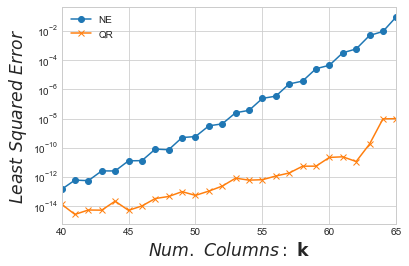

In [7]:
k = [n for n in range(lower_bound, upper_bound + 1)]
plt.semilogy(k, NE_avg_errors, '-o', label='NE')
plt.semilogy(k, QR_avg_errors, '-x', label='QR')

plt.xlim([lower_bound, upper_bound])
plt.xlabel("$Num.\ Columns:\ \\bf{k}$", fontsize='xx-large')
plt.ylabel("$Least\ Squared\ Error$", fontsize='xx-large')
plt.legend()

Text(0, 0.5, '$Condition\\ Number$')

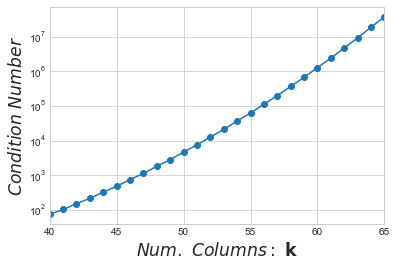

In [8]:
plt.semilogy(k, condition_numbers, '-o')

plt.xlim([lower_bound, upper_bound])
plt.xlabel("$Num.\ Columns:\ \\bf{k}$", fontsize='xx-large')
plt.ylabel("$Condition\ Number$", fontsize='xx-large')

---

##### What's going on specifically?
1. What is the relationship between the error using QR versus the Normal Equations?
    
    - Well, the error is always lower for the QR method and appears to grow slower than the error for NE.


2. What is the relationship between the errors and the condition number of $A_{k}$?
    
    - As $k$ increases, the condition number also increases. Also, in both cases (QR and NE), as $k$ increases the error increases as well. Thus, as the condition number increases, so does the error. The more ill-condtioned the matrix $A$, the more error we are likely to encounter in either method.


3. Suppose your matrix A is ill-conditioned. Which method is more favorable?
    
    - Using the QR factorization method gives preferable results over the NE method the more ill-conditioned the matrix A is.

---

In [9]:
lower_bound = 40
upper_bound = 100

num_bs      = 100

NE_avg_errors = []
QR_avg_errors = []

condition_numbers = []

for k in range(lower_bound, upper_bound + 1):
    # 1: Report size, rank, and condition number for each matrix A_k
    
    A_k          = np.delete(A, [x for x in range(k, size_A[0])], 1)
    size_A_k     = get_size(A_k)
    rank_A_k     = get_rank(A_k)
    cond_num_A_k = get_condition_number(A_k)
    
    condition_numbers.append(cond_num_A_k)
    
    print("Matrix Size: {} x {}{:>10}Rank: {}{:>10}Condition #: {}".format(size_A_k[0], size_A_k[1], '',rank_A_k, '', cond_num_A_k))
    
    # 2 Generate 100 random vectors b_i. For each b_i:    
    b_is = generate_random_bs(size_A_k, num_bs)
    
    x_truth = []
    
    NE_errors = []
    QR_errors = []
    
    i = 0
    
    for b_i in b_is:
        # a.) use np.linalg.lstsq
        x_truth.append(np.linalg.lstsq(A_k, b_i, rcond=None)[0])

        # b.) use our NE
#         NE_errors.append(get_relative_error(NE_solver(A_k, b_i), x_truth[i]))

        # c.) use our QR
        QR_errors.append(get_relative_error(QR_solver(A_k, b_i), x_truth[i]))
        
        i+=1
        
#     NE_avg_errors.append(np.mean(NE_errors))
    QR_avg_errors.append(np.mean(QR_errors))

Matrix Size: 101 x 40          Rank: 40          Condition #: 74.87666090810826
Matrix Size: 101 x 41          Rank: 41          Condition #: 103.8003645382863
Matrix Size: 101 x 42          Rank: 42          Condition #: 152.28560787895904
Matrix Size: 101 x 43          Rank: 43          Condition #: 217.56037976335608
Matrix Size: 101 x 44          Rank: 44          Condition #: 328.8920284188323
Matrix Size: 101 x 45          Rank: 45          Condition #: 483.78052898531325
Matrix Size: 101 x 46          Rank: 46          Condition #: 753.0464969101012
Matrix Size: 101 x 47          Rank: 47          Condition #: 1140.074224074018
Matrix Size: 101 x 48          Rank: 48          Condition #: 1826.7931127929296
Matrix Size: 101 x 49          Rank: 49          Condition #: 2846.422274367003
Matrix Size: 101 x 50          Rank: 50          Condition #: 4695.087418605814
Matrix Size: 101 x 51          Rank: 51          Condition #: 7530.548252627645
Matrix Size: 101 x 52          Rank:

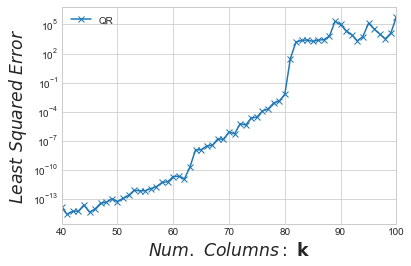

In [10]:
k = [n for n in range(lower_bound, upper_bound + 1)]
plt.semilogy(k, QR_avg_errors, '-x', label='QR')

plt.xlim([lower_bound, upper_bound])
plt.xlabel("$Num.\ Columns:\ \\bf{k}$", fontsize='xx-large')
plt.ylabel("$Least\ Squared\ Error$", fontsize='xx-large')
plt.legend()

Text(0, 0.5, '$Condition\\ Number$')

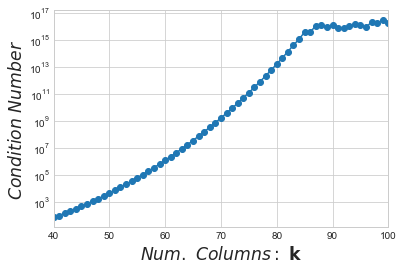

In [11]:
plt.semilogy(k, condition_numbers, '-o')

plt.xlim([lower_bound, upper_bound])
plt.xlabel("$Num.\ Columns:\ \\bf{k}$", fontsize='xx-large')
plt.ylabel("$Condition\ Number$", fontsize='xx-large')

---

##### Bonus 1: Take $k_{max}$ up to 100. Something should break. What broke and why did it break? Any fixes?

- So... the Cholesky method is what breaks.
    - Breaks at size (101 x 67)
    - LinAlgError: Matrix is not positive definite
        - This is with np.linalg.cholesky... Let's try my own method.
            - Cholesky appears to be out, although my method allowed me to get closer to $k=100$, my method doesn't check for the math error that numpy does.
- Without Cholesky method running, I could see the condtion number and rank for every matrix...
    - I remember in lecture, the rank(A) has to equal the number of columns for Cholesky to work.
        - Making sure rank(A) is equal to its number of columns would be one way we could probably fix this. 
        - We might need to tweak A so its positive definite when we take $A^{T}A$ as well.
- I got tired, didn't bother actually fixing the problem :/